# Марковский процесс принятия решений (Markov decision process)

Переход между состояниями задаётся вероятностью $P(s' \mid s,a)$ — насколько вероятно оказаться в состоянии $s'$ после выполнения действия $a$ из состояния $s$. Существует несколько способов задать функцию вознаграждения, но для удобства мы будем использовать функцию $r(s,a,s')$.


Для начала давайте зададим простой MDP (Марковский процесс принятия решений) по этой схеме:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Диаграмма от Waldoalvarez через Wikimedia Commons, CC BY-SA 4.0"/>

In [1]:
# %pip install gym

In [2]:
from mdp import MDP
import numpy as np

In [3]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

In [4]:
mdp = MDP(transition_probs, rewards, initial_state='s0')

Теперь мы можем использовать `MDP` так же, как и любую другую среду из `gym`.


In [5]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


In [6]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


## Итерация ценности (Value Iteration)

Теперь давайте построим что-то, чтобы решить эту MDP. Самый простой алгоритм на данный момент — это **Value Iteration** (итерация ценности).

Вот псевдокод для VI:

---

`1.` Инициализировать $V^{(0)}(s) = 0$ для всех $s$

`2.` Для $i = 0, 1, 2, \dots$

`3.` $ \quad V^{(i+1)}(s) = \max_a \sum_{s'} P(s' \mid s,a) \cdot [ r(s,a,s') + \gamma V^{(i)}(s')]$ для всех $s$

---


Сначала давайте напишем функцию для вычисления функции ценности действия в состоянии $( Q^{\pi} $), определяемой следующим образом:

$$Q_i(s, a) = \sum_{s'} P(s' \mid s,a) \cdot [ r(s,a,s') + \gamma V_i(s')]$$



In [7]:
def get_action_value(mdp, state_values, state, action, gamma):
    """Вычисляет Q(s, a) согласно приведённой выше формуле"""
    
    action_value = 0
    states = mdp.get_next_states(state, action)
    for next_state, prob in states.items():
        action_value += prob*(mdp.get_reward(state, action, next_state) + gamma*state_values[next_state])

    return action_value

Используя $Q(s,a)$ мы теперь можем определить "следующее" V(s) для value iteration.

$$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$



In [8]:
def get_new_state_value(mdp, state_values, state, gamma):
    """Вычисляет новое значение V(s) согласно формуле выше. Пожалуйста, не изменяйте state_values в процессе."""
    if mdp.is_terminal(state):
        return 0

    action_values = []
    actions = mdp.get_possible_actions(state)
    for action in actions:
        action_values.append(get_action_value(mdp, state_values, state, action, gamma))
    new_state_value = np.max(action_values)
    return new_state_value


In [9]:
# параметры
gamma = 0.9            # коэффициент дисконтирования для MDP
num_iter = 100         # максимальное число итераций (не включая инициализацию)

# остановить итерацию ценности (VI), если новые значения близки к старым
min_difference = 0.001

# инициализация V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(num_iter):

    # Вычисляем новые значения состояний с использованием функций, определённых выше.
    # Должен получиться словарь вида {state : float V_new(state)}
    new_state_values = {}
    for state in state_values.keys():
        new_state_values[state] = get_new_state_value(mdp, state_values, state, gamma)

    assert isinstance(new_state_values, dict)

    # Вычисляем разницу
    diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
    print("итерация %4i   |   разница: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Завершено")
        break


итерация    0   |   разница: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
итерация    1   |   разница: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
итерация    2   |   разница: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
итерация    3   |   разница: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
итерация    4   |   разница: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
итерация    5   |   разница: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
итерация    6   |   разница: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
итерация    7   |   разница: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
итерация    8   |   разница: 0.19277   |   V(s0) = 1.868   V(s1) = 5.381   V(s2) = 2.290
итерация    9   |   разница: 0.17327   |   V(s0) = 2.061   V(s1) = 5.573   V(s2) = 2.481
итерация   10   |   разница: 0.15569   |   V(s0) = 2.233   V(s1) = 5.746   V(s2) = 2.654
итерация   11   |   р

In [10]:
print("Final state values:", state_values)

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Теперь давайте используем эти $V^{*}(s)$, чтобы найти оптимальные действия в каждом состоянии:

$$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$

Единственное отличие от V(s) — здесь берётся не максимум, а argmax: находим действие, для которого Q(s,a) максимально.


In [11]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None

    action_values = []
    actions = mdp.get_possible_actions(state)
    for action in actions:
        action_values.append(get_action_value(mdp, state_values, state, action, gamma))
    optimal_action = actions[np.argmax(action_values)]

    return optimal_action

Измерим среднее вознаграждение агента

In [12]:
# Измерим среднее вознаграждение агента

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("среднее вознаграждение: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)


среднее вознаграждение:  0.4521


In [13]:
for state in mdp.get_all_states():
    if not mdp.is_terminal(state):
        best_action = get_optimal_action(mdp, state_values, state, gamma)
        print(f"π*({state}) = {best_action}")

π*(s0) = a1
π*(s1) = a0
π*(s2) = a1


In [14]:
s = mdp.reset()
trajectory = [s]
for _ in range(10):
    a = get_optimal_action(mdp, state_values, s, gamma)
    s, r, done, _ = mdp.step(a)
    trajectory.append(s)
    if done:
        break

print(" → ".join(trajectory[-10:]))

s2 → s2 → s2 → s2 → s1 → s0 → s2 → s0 → s2 → s2


==========================================================================================================================

# Frozen lake

Зима пришла. Вы с друзьями играли в фрисби в парке, когда сделали неудачный бросок, и диск улетел прямо на середину озера. Вода в основном замёрзла, но есть несколько участков с открытыми лунками. Если наступить в одну из них — вы провалитесь в ледяную воду.

Сейчас международный дефицит фрисби, поэтому крайне важно добраться до него, перейдя озеро. Но лёд скользкий — вы не всегда будете двигаться в том направлении, в каком планируете.

Поверхность описывается с помощью такой сетки:

```

SFFF

FHFH

FFFH

HFFG

```

- `S`: стартовая точка, безопасно  
- `F`: замёрзшая поверхность, безопасно  
- `H`: лунка, провалитесь  
- `G`: цель — место, где лежит фрисби

Эпизод заканчивается, когда вы достигли цели или упали в лунку.  
Вы получаете награду 1 при достижении цели, и 0 во всех остальных случаях.
```


In [18]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [19]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """Выполняет num_iter шагов итерации ценности, начиная с state_values. То же самое, что раньше, но в виде функции."""
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Вычисляем новые значения состояний с использованием ранее определённых функций.
        # Должен получиться словарь {state : new_V(state)}
        new_state_values = {}
        for state in state_values.keys():
            new_state_values[state] = get_new_state_value(mdp, state_values, state, gamma)

        assert isinstance(new_state_values, dict)

        # Вычисляем разницу
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())

        print("итерация %4i   |   разница: %6.5f   |   V(старт): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values


In [20]:
state_values = value_iteration(mdp)

итерация    0   |   разница: 1.00000   |   V(старт): 0.000 
итерация    1   |   разница: 0.90000   |   V(старт): 0.000 
итерация    2   |   разница: 0.81000   |   V(старт): 0.000 
итерация    3   |   разница: 0.72900   |   V(старт): 0.000 
итерация    4   |   разница: 0.65610   |   V(старт): 0.000 
итерация    5   |   разница: 0.59049   |   V(старт): 0.590 
итерация    6   |   разница: 0.00000   |   V(старт): 0.590 


In [21]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 0
итерация    0   |   разница: 1.00000   |   V(старт): 0.000 


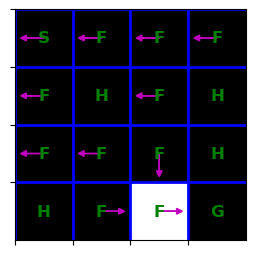

after iteration 1
итерация    0   |   разница: 0.90000   |   V(старт): 0.000 


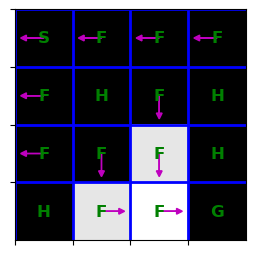

after iteration 2
итерация    0   |   разница: 0.81000   |   V(старт): 0.000 


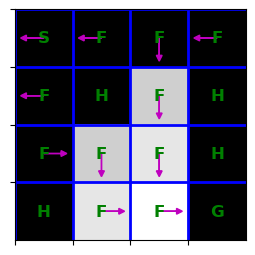

after iteration 3
итерация    0   |   разница: 0.72900   |   V(старт): 0.000 


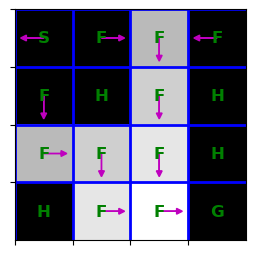

after iteration 4
итерация    0   |   разница: 0.65610   |   V(старт): 0.000 


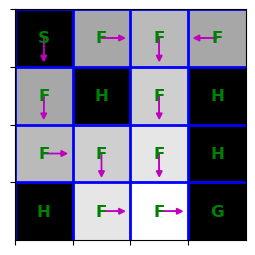

after iteration 5
итерация    0   |   разница: 0.59049   |   V(старт): 0.590 


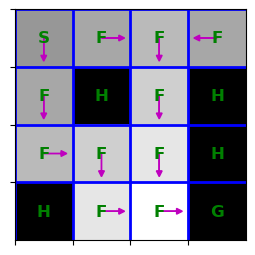

after iteration 6
итерация    0   |   разница: 0.00000   |   V(старт): 0.590 


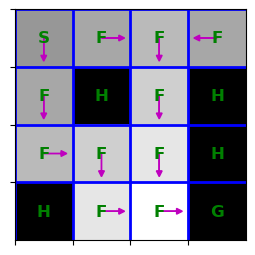

after iteration 7
итерация    0   |   разница: 0.00000   |   V(старт): 0.590 


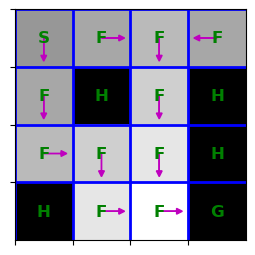

after iteration 8
итерация    0   |   разница: 0.00000   |   V(старт): 0.590 


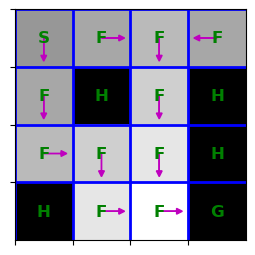

after iteration 9
итерация    0   |   разница: 0.00000   |   V(старт): 0.590 


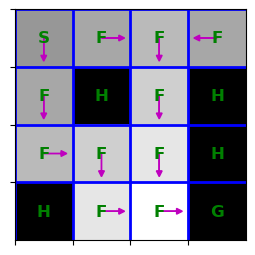

In [23]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
итерация    0   |   разница: 0.00000   |   V(старт): 0.198 


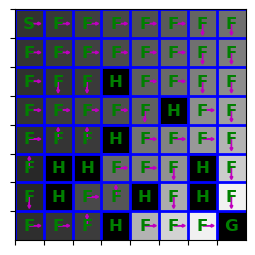

In [24]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

after iteration 29
итерация    0   |   разница: 0.00057   |   V(старт): 0.006 


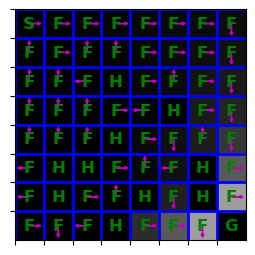

In [25]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.6)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step